In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import io
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import SelectPercentile

In [118]:
# Googleドライブのマウント
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/MachineLearning')

%cd /content/drive/My Drive/MachineLearning
data = pd.read_csv('feature-engineering/data/data-iot-20000.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/MachineLearning


In [89]:
# 文字列データのカラム名を検出
string_columns = data.select_dtypes(include=['object']).columns.tolist()

print(string_columns)

# ワンホットエンコーディングを行う
df = pd.get_dummies(data, columns=string_columns)

['Device_Name', 'Attack', 'Attack_subType']


In [90]:
# カラム数を取得
num_columns = len(df.columns)
print(df.columns)
print(f"Number of columns: {num_columns}")

Index(['MI_dir_L0.1_weight', 'MI_dir_L0.1_mean', 'MI_dir_L0.1_variance',
       'H_L0.1_weight', 'H_L0.1_mean', 'H_L0.1_variance', 'HH_L0.1_weight',
       'HH_L0.1_mean', 'HH_L0.1_std', 'HH_L0.1_magnitude', 'HH_L0.1_radius',
       'HH_L0.1_covariance', 'HH_L0.1_pcc', 'HH_jit_L0.1_weight',
       'HH_jit_L0.1_mean', 'HH_jit_L0.1_variance', 'HpHp_L0.1_weight',
       'HpHp_L0.1_mean', 'HpHp_L0.1_std', 'HpHp_L0.1_magnitude',
       'HpHp_L0.1_radius', 'HpHp_L0.1_covariance', 'HpHp_L0.1_pcc', 'label',
       'Device_Name_Danmini_Doorbell', 'Attack_Normal', 'Attack_gafgyt',
       'Attack_subType_Normal', 'Attack_subType_combo'],
      dtype='object')
Number of columns: 29


In [109]:
# ターゲット変数の設定
X = df.drop(columns=['label'])  #　labelを除外して特徴量として使用
y = df['label']  # labelをターゲット変数として使用

# このままだと面白くないので、カラムを落とす
X = X.drop(columns=X.columns[-15:])

# データをトレーニングセットとテストセットに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [110]:
# ロジスティック回帰モデルを作成
model = LogisticRegression()
model.fit(X_train, y_train)

# テストセットを使って予測
y_pred = model.predict(X_test)

# 予測結果の評価
print("線形モデルの正確度:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

線形モデルの正確度: 0.9995
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3017
           1       1.00      1.00      1.00      2983

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [111]:
# 決定木で学習
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)
y_pred_dt = dt_clf.predict(X_test)
print(f"決定木の正確度: {accuracy_score(y_test, y_pred_dt)*100:.2f}%")

# ランダムフォレストで学習
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
print(f"ランダムフォレストの正確度: {accuracy_score(y_test, y_pred_rf)*100:.2f}%")

決定木の正確度: 99.97%
ランダムフォレストの正確度: 99.95%


X_train.shape: (14000, 13)
X_train_selected.shape: (14000, 6)
[ True  True False  True  True False  True False False  True False False
 False]


Text(0.5, 0, 'Sample index')

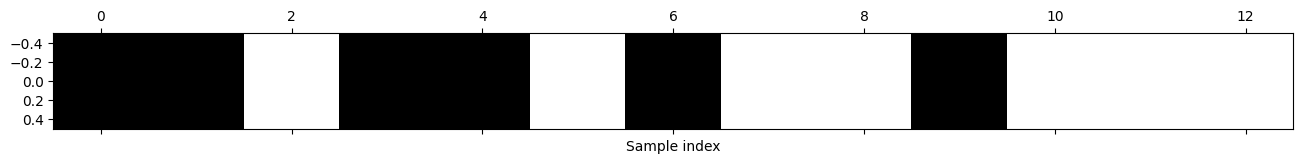

In [112]:
# 単変量測定を行う
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)

# 訓練セットを変換
X_train_selected = select.transform(X_train)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

# 結果の可視化--黒が真、白が偽
mask = select.get_support()
print(mask)
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")

In [113]:
# 線形回帰の比較
X_test_selected = select.transform(X_test)

#　全ての特徴量を用いる
model.fit(X_train, y_train)
print("Score with all  features: {:.3f}".format(model.score(X_test, y_test)))

# 選択された特徴量だけを用いる
model.fit(X_train_selected, y_train)
print("Score with only selected features: {:.3f}".format(model.score(X_test_selected, y_test)))

Score with all  features: 1.000
Score with only selected features: 1.000


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


X_train.shape: (14000, 13)
X_train_l1.shape: (14000, 7)
Test score: 1.000


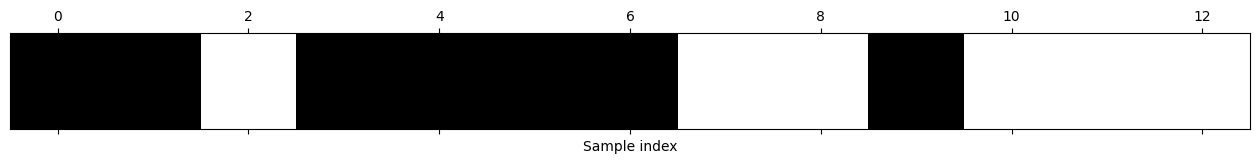

In [114]:
# モデルベース特徴量選択
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
select = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold="median")

select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_l1.shape: {}".format(X_train_l1.shape))

mask = select.get_support()
# visualize the mask. black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

X_test_l1 = select.transform(X_test)
score = LogisticRegression(max_iter=1000).fit(X_train_l1, y_train).score(X_test_l1, y_test)
print("Test score: {:.3f}".format(score))

Test score: 1.000
Test score: 1.000


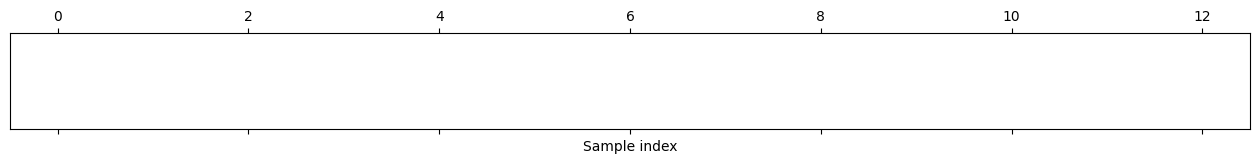

In [115]:
# 反復特徴量選択

from sklearn.feature_selection import RFE
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42),
             n_features_to_select=40)

select.fit(X_train, y_train)
# visualize the selected features:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)

score = LogisticRegression(max_iter=1000).fit(X_train_rfe, y_train).score(X_test_rfe, y_test)
print("Test score: {:.3f}".format(score))
print("Test score: {:.3f}".format(select.score(X_test, y_test)))